<h2>This is early work file with implementation attempt of Robust Real-Time Face Detection paper by P. Viola and M. Jones</h2>

<h3>This is implementation of the algorithm using ready library cv2 providing useful features for image processing and feature detection.</h3>

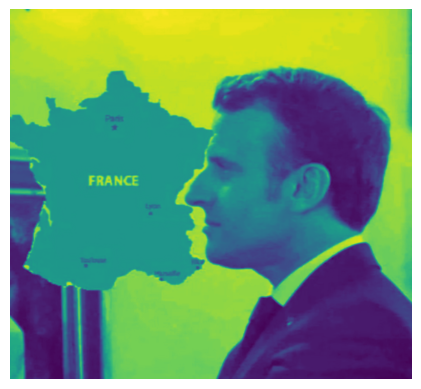

In [20]:
import cv2
import matplotlib.pyplot as plt

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

image_path = './images/france.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(
    gray, 
    scaleFactor=1.1, 
    minNeighbors=5, 
    minSize=(30, 30), 
    flags=cv2.CASCADE_SCALE_IMAGE
)

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.imshow(gray)
plt.axis('off')
plt.show()

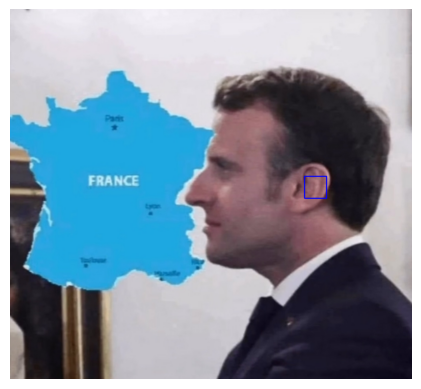

In [21]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

<h2>Code for Core components</h2>
<h3>Integral Image Compute</h3>
Calculates cumulative sum on two axis for all pixels, then returns the Numpy Array.

In [2]:
import numpy as np

def compute_integral_image(img):
    integral = np.cumsum(np.cumsum(img, axis=0), axis=1)
    return integral

In [ ]:
class HaarFeature:
    def __init__(self, feature_type, position, width, height):
        self.feature_type = feature_type  # 'two-rectangle'
        self.position = position  # (x, y)
        self.width = width
        self.height = height

    def compute_value(self, integral_img):
        x, y = self.position
        w, h = self.width, self.height

        if self.feature_type == 'two-rectangle-horizontal':
            A = self.sum_region(integral_img, x, y, w // 2, h)
            B = self.sum_region(integral_img, x + w // 2, y, w // 2, h)
            return A - B
        elif self.feature_type == 'two-rectangle-vertical':
            A = self.sum_region(integral_img, x, y, w, h // 2)
            B = self.sum_region(integral_img, x, y + h // 2, w, h // 2)
            return A - B
        elif self.feature_type == 'three-rectangle-horizontal':
            A = self.sum_region(integral_img, x, y, w //3, h)
            B = self.sum_region(integral_img, x + w // 3, y, w // 3, h)
            C = self.sum_region(integral_img, x + 2*(w // 3), y, w // 3, h)
            return A - B + C
        elif self.feature_type == 'three-rectangle-vertical':
            A = self.sum_region(integral_img, x, y, w, h // 3)
            B = self.sum_region(integral_img, x, y + h // 3, w, h // 3)
            C = self.sum_region(integral_img, x, y + 2*(h // 3), w, h // 3)
            return A - B + C
        elif self.feature_type == 'four-rectangle':
            A = self.sum_region(integral_img, x, y, w // 2, h // 2)
            B = self.sum_region(integral_img, x + w // 2, y, w // 2, h // 2)
            C = self.sum_region(integral_img, x, y + h // 2, w // 2, h // 2)
            D = self.sum_region(integral_img, x + w // 2, y + h // 2, w // 2, h // 2)
            return A - B - C + D

    def sum_region(self, integral_img, x, y, w, h):
        A = integral_img[y-1, x-1] if y > 0 and x > 0 else 0
        B = integral_img[y-1, x+w-1] if y > 0 else 0
        C = integral_img[y+h-1, x-1] if x > 0 else 0
        D = integral_img[y+h-1, x+w-1]
        return D - B - C + A


<h3>Weak Classifer of the Viola Jones algorithm</h3>

In [3]:
class WeakClassifier:
    def __init__(self, feature, threshold, polarity):
        self.feature = feature
        self.threshold = threshold
        self.polarity = polarity

    def predict(self, integral_img):
        feature_value = self.feature.compute_value(integral_img)
        return 1 if self.polarity * feature_value < self.polarity * self.threshold else 0

<h2>AdaBoost early concept</h2>

In [ ]:
class AdaBoost:
    def __init__(self, num_classifiers):
        self.num_classifiers = num_classifiers
        self.strong_classifier = []

    def train(self, training_data, labels, features):
        num_samples = len(training_data)
        weights = np.ones(num_samples) / num_samples

        for _ in range(self.num_classifiers):
            best_classifier = None
            best_error = float('inf')
            best_pred = None

            for feature in features:
                for threshold in np.linspace(-1000, 1000, 20): 
                    for polarity in [1, -1]:
                        classifier = WeakClassifier(feature, threshold, polarity)
                        predictions = np.array([classifier.predict(img) for img in training_data])
                        error = np.sum(weights * (predictions != labels))

                        if error < best_error:
                            best_error = error
                            best_classifier = classifier
                            best_pred = predictions
            #parameters
            epsilon = 1e-10
            alpha = 0.5 * np.log((1 - best_error) / (best_error + epsilon))
            weights *= np.exp(-alpha * labels * (2 * best_pred - 1))
            weights /= np.sum(weights)

            self.strong_classifier.append((alpha, best_classifier))

    def predict(self, integral_img):
        total = sum(alpha * (2 * clf.predict(integral_img) - 1)
                    for alpha, clf in self.strong_classifier)
        return 1 if total >= 0 else 0